The purpose of this notebook is to investigate the behavior of the amplitude of RIPSPs on a single motoneuron when the whole population of renshaw cells is activate by a nerve stimulation.

In [21]:
import sys
sys.path.insert(0, '..')
# Allows plots to be zoomed in, etc
%matplotlib notebook

import matplotlib.pyplot as plt
import numpy as np

from Configuration import Configuration
from MotorUnitPool import MotorUnitPool
from InterneuronPool import InterneuronPool
from SynapsesFactory import SynapsesFactory

We set the parameters to equal those on the online version of remoto. Those can be checked in conf.confArray, in which 'f0' stands for the name of the field, whereas 'f1' stands for the first value and 'f2' for the second. Therefore, 'f0' is used to find the parameter index so further modifications can be made.

In [22]:
conf = Configuration('confRIPSP1.rmto')

# Number of cells
idx = np.where(conf.confArray['f0']=='MUnumber_SOL-S')[0][0]
conf.confArray['f1'][idx] = 1
idx = np.where(conf.confArray['f0']=='MUnumber_SOL-FR')[0][0]
conf.confArray['f1'][idx] = 1
idx = np.where(conf.confArray['f0']=='MUnumber_SOL-FF')[0][0]
conf.confArray['f1'][idx] = 1
idx = np.where(conf.confArray['f0']=='Number_RC_ext')[0][0]
conf.confArray['f1'][idx] = 350

# PTN stimulus
idx = np.where(conf.confArray['f0']=='stimStart_PTN')[0][0]
conf.confArray['f1'][idx] = 2
idx = np.where(conf.confArray['f0']=='stimStop_PTN')[0][0]
conf.confArray['f1'][idx] = 500
idx = np.where(conf.confArray['f0']=='stimIntensity_PTN')[0][0]
conf.confArray['f1'][idx] = 20
idx = np.where(conf.confArray['f0']=='stimFrequency_PTN')[0][0]
conf.confArray['f1'][idx] = 2
idx = np.where(conf.confArray['f0']=='stimModulationStart_PTN')[0][0]
conf.confArray['f1'][idx] = 0
idx = np.where(conf.confArray['f0']=='stimModulationStop_PTN')[0][0]
conf.confArray['f1'][idx] = 0

# To avoid SOL from firing
idx = np.where(conf.confArray['f0']=='gmax_Na:SOL-S@soma')[0][0]
conf.confArray['f1'][idx] = 0
idx = np.where(conf.confArray['f0']=='gmax_Na:SOL-FR@soma')[0][0]
conf.confArray['f1'][idx] = 0
idx = np.where(conf.confArray['f0']=='gmax_Na:SOL-FF@soma')[0][0]
conf.confArray['f1'][idx] = 0
# To make noise fire action pontentials (<0.3: EPSPs, >0.3: too much spikes)
idx = np.where(conf.confArray['f0']=='gmax:Noise>RC_ext-@soma|excitatory')[0][0]
conf.confArray['f1'][idx] = 0.3

# Parameters from java
## Connectivity
idx = np.where(conf.confArray['f0']=='Con:RC_ext->SOL-S@soma|inhibitory')[0][0]
conf.confArray['f1'][idx] = 100
idx = np.where(conf.confArray['f0']=='Con:RC_ext->SOL-FR@soma|inhibitory')[0][0]
conf.confArray['f1'][idx] = 100
idx = np.where(conf.confArray['f0']=='Con:RC_ext->SOL-FF@soma|inhibitory')[0][0]
conf.confArray['f1'][idx] = 100
idx = np.where(conf.confArray['f0']=='Con:SOL-S>RC_ext-@soma|excitatory')[0][0]
conf.confArray['f1'][idx] = 100
idx = np.where(conf.confArray['f0']=='Con:SOL-FR>RC_ext-@soma|excitatory')[0][0]
conf.confArray['f1'][idx] = 100
idx = np.where(conf.confArray['f0']=='Con:SOL-FF>RC_ext-@soma|excitatory')[0][0]
conf.confArray['f1'][idx] = 100

## Conductances
idx = np.where(conf.confArray['f0']=='gmax:RC_ext->SOL-S@soma|inhibitory')[0][0]
conf.confArray['f1'][idx] = 0.44
idx = np.where(conf.confArray['f0']=='gmax:RC_ext->SOL-FR@soma|inhibitory')[0][0]
conf.confArray['f1'][idx] = 0.3
idx = np.where(conf.confArray['f0']=='gmax:RC_ext->SOL-FF@soma|inhibitory')[0][0]
conf.confArray['f1'][idx] = 0.24
idx = np.where(conf.confArray['f0']=='gmax:SOL-S>RC_ext-@soma|excitatory')[0][0]
conf.confArray['f1'][idx] = 0.15
idx = np.where(conf.confArray['f0']=='gmax:SOL-FR>RC_ext-@soma|excitatory')[0][0]
conf.confArray['f1'][idx] = 0.17
idx = np.where(conf.confArray['f0']=='gmax:SOL-FF>RC_ext-@soma|excitatory')[0][0]
conf.confArray['f1'][idx] = 0.3

## Morphology
idx = np.where(conf.confArray['f0']=='d@soma:RC_ext-')[0][0]
conf.confArray['f1'][idx] = 65
conf.confArray['f2'][idx] = 65
idx = np.where(conf.confArray['f0']=='l@soma:RC_ext-')[0][0]
conf.confArray['f1'][idx] = 285
conf.confArray['f2'][idx] = 285
idx = np.where(conf.confArray['f0']=='res@soma:RC_ext-')[0][0]
conf.confArray['f1'][idx] = 200
conf.confArray['f2'][idx] = 200

Muscle spindle from muscle SOL built.
Motor Unit Pool SOL built
Interneuron Pool of RC ext built
All the 2100 synapses were built
Synaptic Noise on RC_ext built
All the 350 synaptic noises were built


<IPython.core.display.Javascript object>


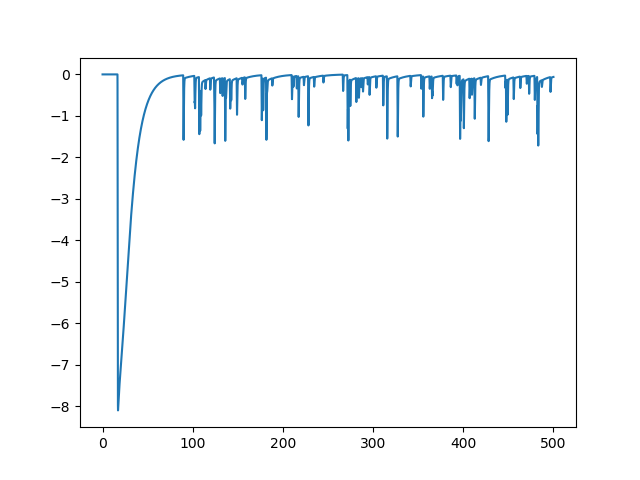

In [23]:
pools = dict()
pools[0] = MotorUnitPool(conf, 'SOL')
pools[1] = InterneuronPool(conf, 'RC', 'ext')

# PTN stimulus delivered to motor units
for i in xrange(0,len(pools[0].unit)):
    pools[0].unit[i].createStimulus()
    
Syn = SynapsesFactory(conf, pools)

t = np.arange(0.0, conf.simDuration_ms, conf.timeStep_ms)

RC_mV = np.zeros_like(t)
MN_mV = np.zeros_like(t)

for i in xrange(0, len(t)):
    pools[0].atualizeMotorUnitPool(t[i]) # MN pool
    pools[2].atualizePool(t[i]) # RC synaptic Noise
    pools[1].atualizeInterneuronPool(t[i]) # RC pool
    RC_mV[i] = pools[1].unit[0].v_mV[0] 
    MN_mV[i] = pools[0].unit[0].v_mV[1] 

pools[0].listSpikes()

plt.figure()
plt.plot(t, MN_mV, '-')
plt.show()

<IPython.core.display.Javascript object>


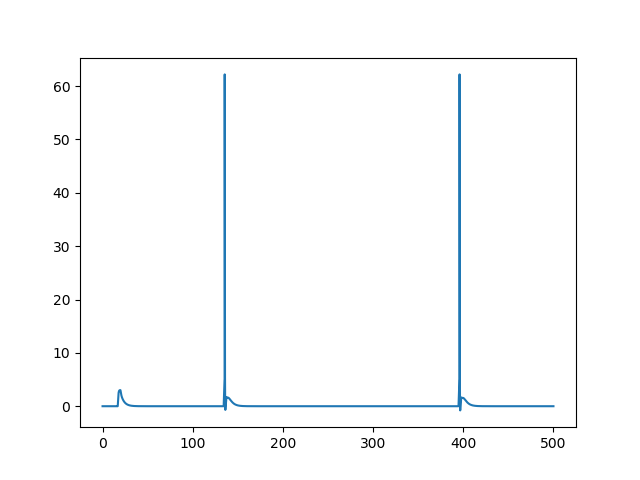

In [24]:
plt.figure()
plt.plot(t, RC_mV, '-')
plt.show()